# Part 1 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

Image Shape (393, 265, 3)


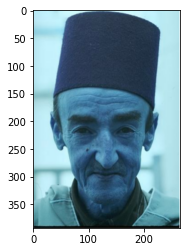

In [ ]:
img= cv2.imread('cortoonify.png')
plt.imshow(img)
print(f"Image Shape {img.shape}")

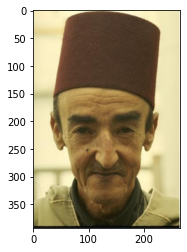

In [ ]:
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(imgRGB);

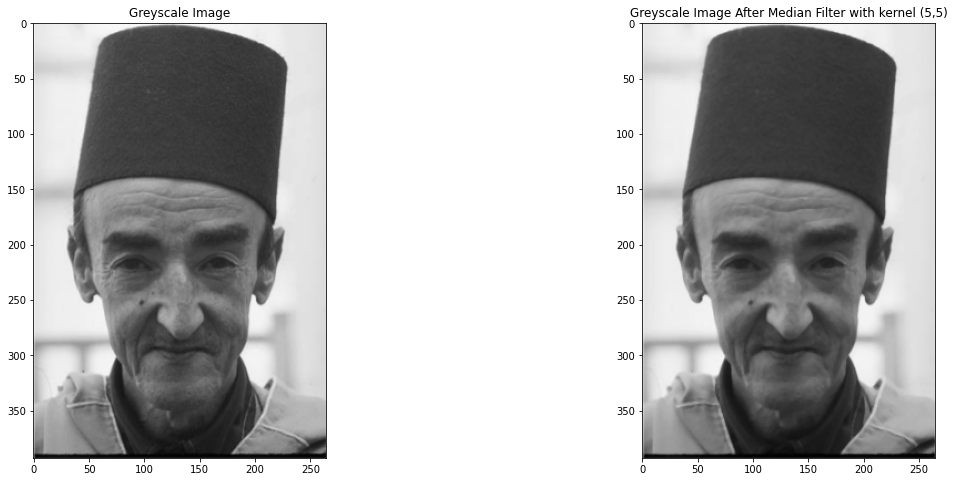

In [ ]:
img_gray= cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)
median_blur=cv2.medianBlur(img_gray,3)
figure = plt.figure(figsize=(20,8))
org_grey =figure.add_subplot(1,2,1)
org_grey.imshow(img_gray, cmap='gray')
org_grey.title.set_text("Greyscale Image")
median_op =figure.add_subplot(1,2,2)
median_op.imshow(median_blur, cmap='gray')
median_op.title.set_text("Greyscale Image After Median Filter with kernel (5,5)")

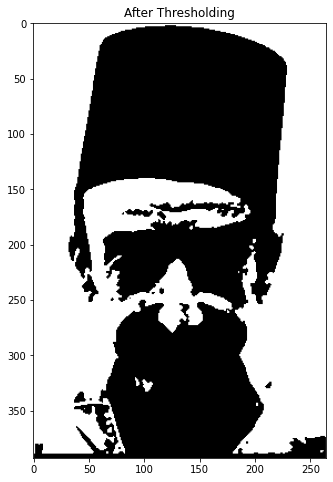

In [ ]:
_, thresh_img=cv2.threshold(median_blur,120,255,cv2.THRESH_BINARY_INV)
plt.figure(figsize=(20,8))
plt.imshow(thresh_img, cmap='binary');
plt.title("After Thresholding");

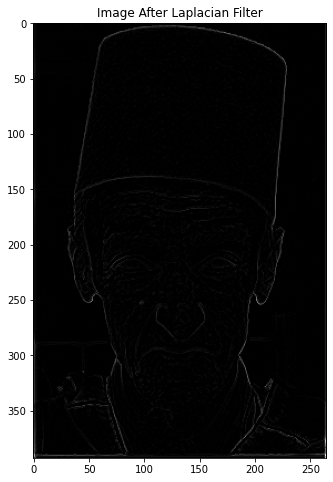

In [ ]:
lablacian_img= cv2.Laplacian(median_blur,cv2.CV_8U)
plt.figure(figsize=(20,8))
plt.imshow(lablacian_img,cmap='gray')
plt.title("Image After Laplacian Filter");

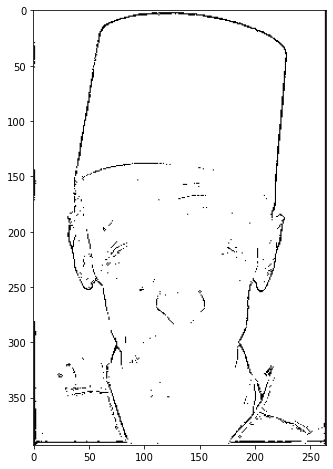

In [ ]:
_, thresh_img=cv2.threshold(lablacian_img,20,255,cv2.THRESH_BINARY_INV)
plt.figure(figsize=(20,8))
plt.imshow(thresh_img,cmap='gray')

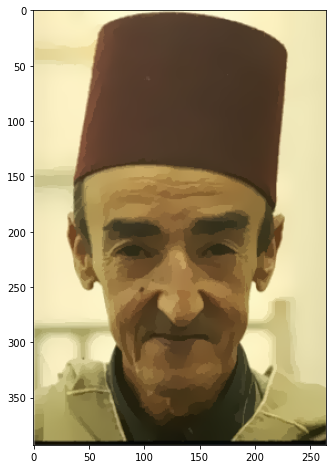

In [ ]:
bilateral_img=cv2.bilateralFilter(imgRGB,9,9,7)
bilateral_img=cv2.bilateralFilter(bilateral_img,9,9,7)
bilateral_img=cv2.bilateralFilter(bilateral_img,9,9,7)
bilateral_img=cv2.bilateralFilter(bilateral_img,9,9,7)
bilateral_img=cv2.bilateralFilter(bilateral_img,9,9,7)
bilateral_img=cv2.bilateralFilter(bilateral_img,9,9,7)
bilateral_img=cv2.bilateralFilter(bilateral_img,9,9,7)
bilateral_img=cv2.bilateralFilter(bilateral_img,9,9,7)
bilateral_img=cv2.bilateralFilter(bilateral_img,9,9,7)
bilateral_img=cv2.bilateralFilter(bilateral_img,9,9,7)
bilateral_img=cv2.bilateralFilter(bilateral_img,9,9,7)
bilateral_img=cv2.bilateralFilter(bilateral_img,9,9,7)
bilateral_img=cv2.bilateralFilter(bilateral_img,9,9,7)

bilateral_img_BGR = cv2.cvtColor(bilateral_img, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(20,8))
plt.imshow(bilateral_img)

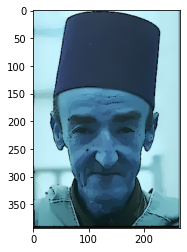

In [ ]:
sketch=cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2RGB)
out_img=cv2.addWeighted(bilateral_img, 1, sketch,1, -255)
out_img_BGR=cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
plt.imshow(out_img_BGR);

## ===========================================================================

# Part 2  

In [ ]:
class My_Hough():
    def __init__(self,
                rho_finess : int,
                theta_finess : int,
                threshold : int):
        """
        Arguments : 
            rho_finess : int
                for rho accuracy -> number of rhos to consider
                rho range is from -d to d , where d is the hypotenuse of the a quadrant 
            theta_finess : int
                for theta accuracy -> number of theta to consider
                theta range is from 0 to 180 DEGREES
            min_votes : int
                mininum votes to consider an edge.
        """
        self.rho_finess = rho_finess
        self.theta_finess = theta_finess 
        self.threshold = threshold
    
    def detect(self,
               original_image : np.ndarray,
               detected_edges_image : np.ndarray,
               plot=True):
        
        """
        Arguments : 
            original_image : np.ndarray
                The image which lines will be plotted on
            detected_edges_image : np.ndarray
                Image after canny edge detection, Greyscale image
        """
        assert len(detected_edges_image.shape) == 2, "Edge Image should be Greyscale"
        assert detected_edges_image.shape == original_image.shape[:2] , "Original and Edge Images should have the same dimensions"
        
        y_max, x_max = detected_edges_image.shape
        
        rho_max = np.sqrt((y_max/2)**2 + (x_max/2)**2) #calculating hypotenuse
        rho_dim = 2*rho_max / self.rho_finess  # upper right and lower left hypotenuse 
        
        theta_dim = 180/self.theta_finess
        
        thetas_linspace = np.arange(0, 180, step=theta_dim)
        rho_linspace = np.arange(-rho_max, rho_max, step=rho_dim)
        
        cosine_thetas = np.cos(np.deg2rad(thetas_linspace))
        sin_thetas = np.sin(np.deg2rad(thetas_linspace))
        
        H = np.zeros((len(rho_linspace), len(thetas_linspace)))
        
        edge_pixels_positions = np.argwhere(detected_edges_image != 0)
        
        edge_pixels_positions = edge_pixels_positions - np.array([[y_max//2, x_max//2]]) #treating the center of the image as origin, transferring the indices with respect to the new origing
          
        rhos_vals = np.matmul(edge_pixels_positions, np.array([sin_thetas, cosine_thetas])) # vectorized implemntation of rho = x cos_theta + y sin_theta

                                                    
        H, thetas, rhos = np.histogram2d(
                                        x = np.tile(A = thetas_linspace, reps = rhos_vals.shape[0]),
                                        y = rhos_vals.ravel(),
                                        bins = [thetas_linspace, rho_linspace]
                                        )
        
        H = H.T
        #############################
        self.threshold = 0.5 * H.max()
        #############################
        detected_lines = np.argwhere(H > self.threshold)
        
        lines_rhos_idx, lines_theta_idx = detected_lines[:,0], detected_lines[:,1]
        r,t = rhos[lines_rhos_idx], thetas[lines_theta_idx]
        
        if plot : 
            figure = plt.figure(figsize=(40, 40))
        
            ## plotting original image 
            original_image_plot = figure.add_subplot(2,2,1)
            original_image_plot.imshow(original_image)
            original_image_plot.title.set_text("Original Image")
            
            #plotting edges image
            edges_image_plot = figure.add_subplot(2,2,2)
            edges_image_plot.imshow(detected_edges_image,cmap='gray')
            edges_image_plot.title.set_text("Image After Edge Detection")
            
            #plotting hough space and detected eges in final output 
            hough_plot = figure.add_subplot(2,2,3)
            hough_plot.set_facecolor((0, 0, 0))
            output_image_plot = figure.add_subplot(2,2,4)
            output_image = np.copy(original_image)  
            
            for rho_val_tup in rhos_vals:
                hough_plot.plot(thetas_linspace, rho_val_tup, color="red", alpha=0.05)

            for line in detected_lines:
                y, x = line #getting the rho_bin 
                rho = rho_linspace[y]
                theta = thetas_linspace[x]
                bin_rho = np.digitize(rho, rhos)
                bin_theta = np.digitize(theta, thetas) 
                candidates_bins = np.digitize(rhos_vals[:,int(theta)], rhos)
                try:
                    max_point = (np.argwhere(bin_rho == candidates_bins)).max()
                    min_point = (np.argwhere(bin_rho == candidates_bins)).min()
                    y1,x1 = edge_pixels_positions[min_point] + np.array([y_max//2, x_max//2])
                    y2,x2 = edge_pixels_positions[max_point] + np.array([y_max//2, x_max//2])
                    output_image = cv2.line(output_image, (x1,y1), (x2,y2), (0, 255, 0), 2)
                    hough_plot.scatter([theta], [rho], marker='x',color="yellow",s=2000,zorder=1000)
                except : 
                    continue
                
            output_image_plot.imshow(output_image)
            
            hough_plot.invert_yaxis()
            hough_plot.invert_xaxis()
            hough_plot.title.set_text("Hough Normal Space")
            output_image_plot.title.set_text("Output Image")
            plt.show()
        else : 
            
            return H, rho_linspace, thetas_linspace        

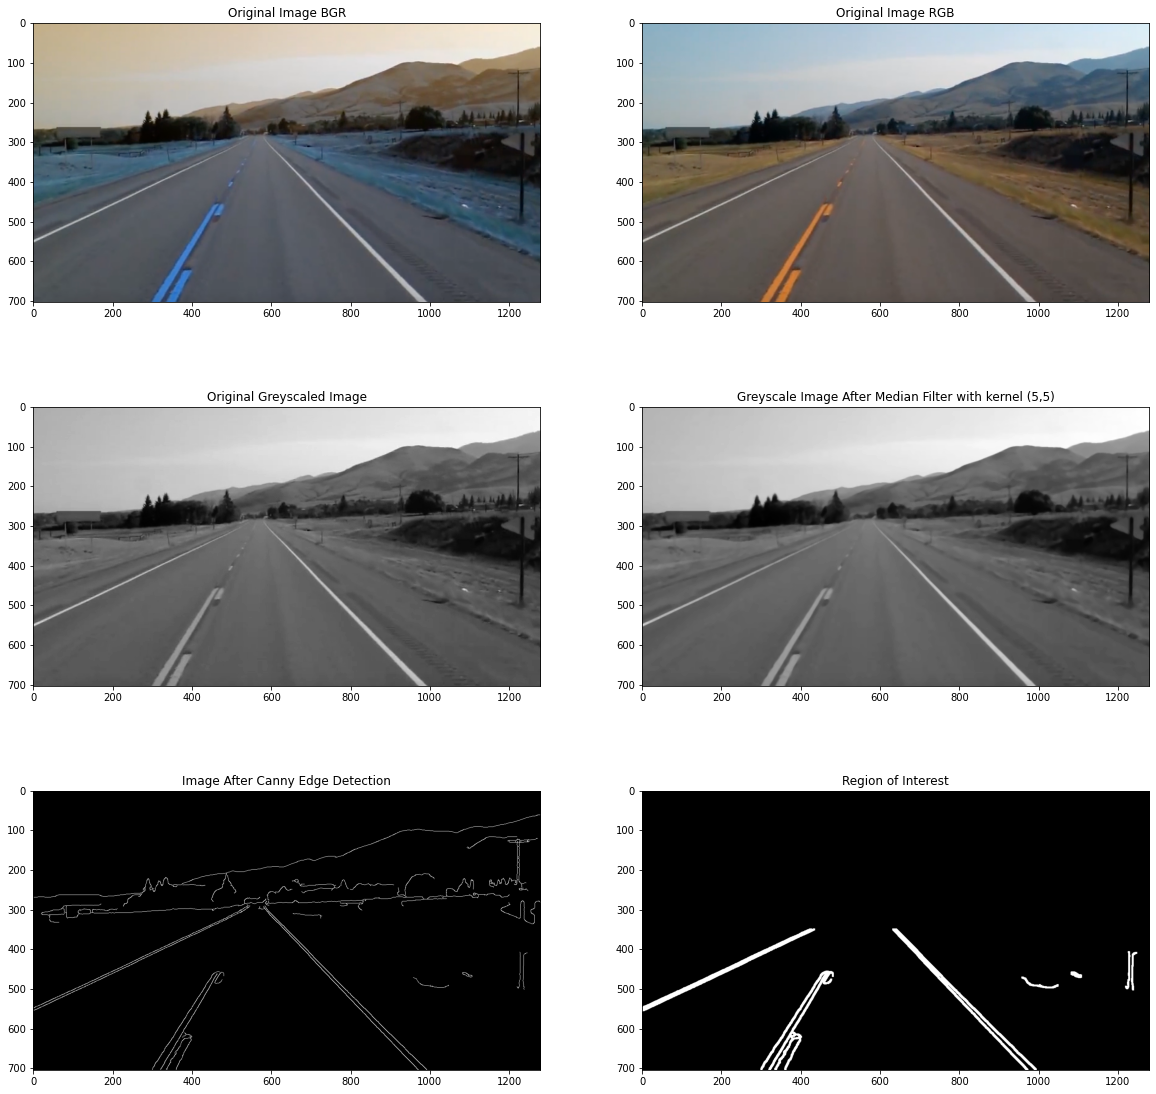

In [ ]:
image_bgr = cv2.imread('img.png')
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image_grayscale_blurred = cv2.medianBlur(image_grayscale, 7)
canny_edges_woroi = cv2.Canny(image_grayscale_blurred, 0, 150)
canny_edges_wroi = np.copy(canny_edges_woroi)
canny_edges_wroi[0:350,:] = 0
kernel = np.ones((5, 5), np.uint8)
canny_edges_wroi = cv2.dilate(canny_edges_wroi, kernel, iterations=1)

figure = plt.figure(figsize=(20,20))

original_ax_BGR =figure.add_subplot(3,2,1)
original_ax_BGR.imshow(image_bgr)
original_ax_BGR.title.set_text("Original Image BGR")

original_ax =figure.add_subplot(3,2,2)
original_ax.imshow(image)
original_ax.title.set_text("Original Image RGB")

original_grey_ax =figure.add_subplot(3,2,3)
original_grey_ax.imshow(image_grayscale, cmap='gray')
original_grey_ax.title.set_text("Original Greyscaled Image")

median_op =figure.add_subplot(3,2,4)
median_op.imshow(image_grayscale_blurred, cmap='gray')
median_op.title.set_text("Greyscale Image After Median Filter with kernel (5,5)")

canny_edges_ax =figure.add_subplot(3,2,5)
canny_edges_ax.imshow(canny_edges_woroi, cmap='gray')
canny_edges_ax.title.set_text("Image After Canny Edge Detection")

canny_edges_ax_roi =figure.add_subplot(3,2,6)
canny_edges_ax_roi.imshow(canny_edges_wroi, cmap='gray')
canny_edges_ax_roi.title.set_text("Region of Interest")

In [ ]:
my_hough = My_Hough(rho_finess=180,
                   theta_finess=180,
                   threshold=600)

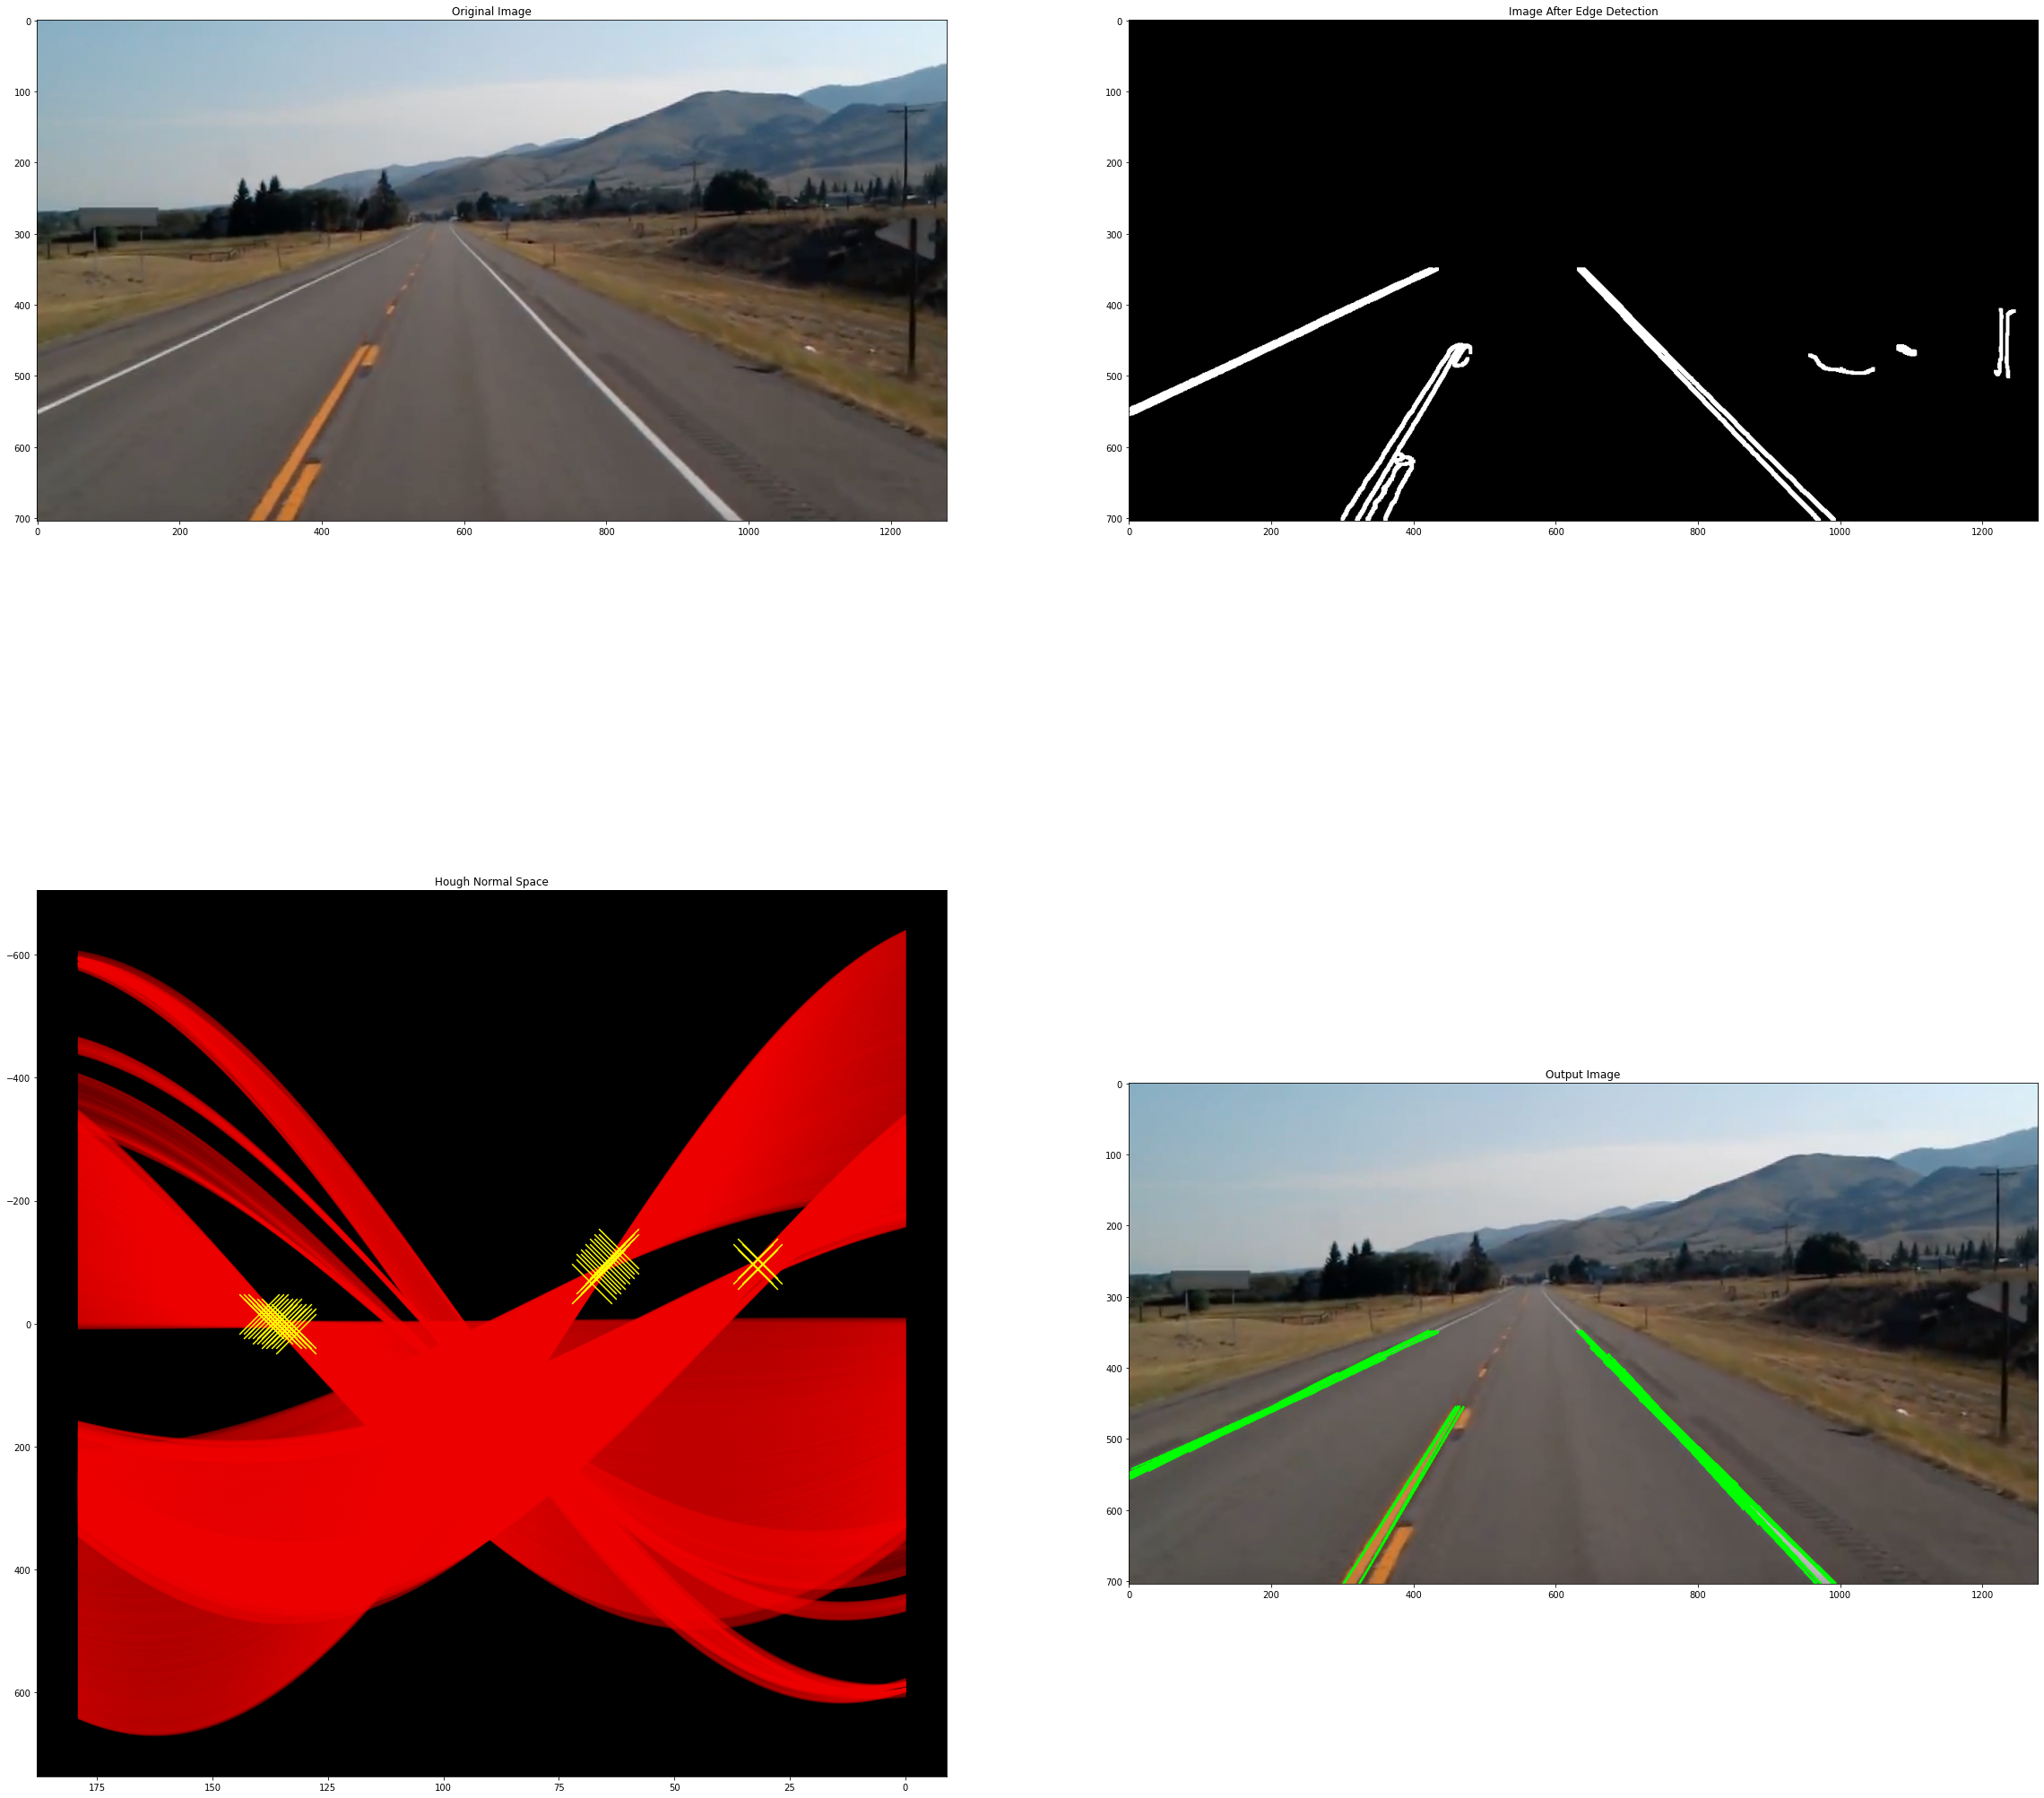

In [ ]:
my_hough.detect(original_image=image,
                detected_edges_image=canny_edges_wroi,
                plot=True)